# LTSF-Linear family
- Linear : one linear layer
- DLinear : Decomposition Linear -> trend와 seasonality 패턴을 핸들링
- NLinear : 정규화된 Linear로서 train-test set 분포 변화를 다룬다. 

In [1]:
import pandas as pd 
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import os
from torch.utils.data import DataLoader
from torch.utils.data import Dataset


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings('ignore')

import time
import random
from tqdm import tqdm
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler


In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f'{device} is available.')

cuda is available.


In [3]:
config = {
    'batch_size': 32, # 일반적으로 32, 64 크기의 mini-batch가 성능에는 가장 좋다고 알려져 있다.
    'epoch': 50, # 이건 어느정도 해야하지
    'learning_rate' : 1e-2,
    'seq_len': 72, # look_back_window_size
    # 'label_len':2, # 이건 뭘까
    'pred_len': 24, # forecasting step인거같고
    'individual' : False,
    'enc_in':0 # feature column 개수?
}

# dlinear_size = [config['seq_len'], config['label_len'], config['pred_len']]


In [4]:
# torch를 사용할 때 seed 고정
def seed_everything(seed: int = 311):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed) # type: ignore
    torch.backends.cudnn.deterministic = True # type : ignore
    torch.backends.cudnn.benchmark = True # type:ignore


seed_everything()

# 데이터 불러오기 & 전처리
- 일단 환율만

In [5]:
import FinanceDataReader as fdr


df = fdr.DataReader('USD/KRW') # 모든 일자 가져오기
df = df.interpolate() # 결측치 채우기
df.reset_index(inplace=True)
df = df[['Date', 'Close']]
df 


,Date,Close
0,2003-12-01,1198.400024
1,2003-12-02,1195.000000
2,2003-12-03,1192.500000
3,2003-12-04,1190.099976
4,2003-12-05,1184.699951
...,...,...
5045,2023-04-03,1305.479980
5046,2023-04-04,1308.050049
5047,2023-04-05,1312.410034
5048,2023-04-06,1316.209961


In [6]:
df.head(5)

,Date,Close
0,2003-12-01,1198.400024
1,2003-12-02,1195.000000
2,2003-12-03,1192.500000
3,2003-12-04,1190.099976
4,2003-12-05,1184.699951


### DLinear
- DLinear : Autoformer와 FEDformer에서 사용되는 시계열 분해 방식을 선형 레이어와 결합한 모델.
1) 먼저 이동 평균값을 만들고 이를 제거하여 각각 학습하기 위해 추세와 주기성 데이터로 분해.
2) 그런 다음 각 구성 요소에 단일 선형 레이어를 적용하여 학습하고 두 개를 합산하여 최종 예측을 계산
3) Dlinear는 시계열 데이터의 명확한 추세와 주기성이 있을 때 바닐라 선형 모델보다 더 나은 성능을 가질 수 있다.

# Multi Step Forecasting

In [7]:
class moving_avg(nn.Module):
    '''
    Moving average block to highlight the trend of time series
    '''
    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size = kernel_size, stride = stride, padding = 0)

    def forward(self, x):
        # padding on the both ends of time series
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        end = x[:, -1:, :].repeat(1, (self.kernel_size -1) //2, 1)
        x = torch.cat([front, x, end], dim=1)
        x = self.avg(x.permute(0, 2, 1)) 
        x = x.permute(0,2,1) # 차원 순서바꾸기
        return x
    

class series_decomp(nn.Module):
    '''
    Series decomposition block
    '''
    def __init__(self, kernel_size):
        super(series_decomp, self).__init__()
        self.moving_avg = moving_avg(kernel_size, stride=1)

    def forward(self, x):
        moving_mean = self.moving_avg(x)
        res = x - moving_mean
        
        return res, moving_mean
    

class DLinear(nn.Module):
    """
    DLinear model
    """
    def __init__(self, configs):
        super(DLinear, self).__init__()
        self.seq_len = configs['seq_len']
        self.pred_len = configs['pred_len']

        # Decomposition Kernel Size
        kernel_size = 25
        self.decomposition = series_decomp(kernel_size) # 리턴값이 두개인데..
        self.individual = configs['individual'] # individual
        self.channels = configs['enc_in'] # feature_size 

        if self.individual:
            self.Linear_Seasonal = nn.ModuleList() # 리스트 초기화 선언 같은거
            self.Linear_Trend = nn.ModuleList()

            for i in range(self.channels): # feature_size 만큼 -> 컬럼 개수만큼
                self.Linear_Trend.append(nn.Linear(self.seq_len, self.pred_len))
                self.Linear_Trend[i].weight = nn.Parameter((1/self.seq_len) * torch.ones([self.pred_len, self.seq_len]))
                self.Linear_Seasonal.append(nn.Linear(self.seq_len, self.pred_len))
                self.Linear_Seasonal[i].weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len, self.seq_len]))
        else:
            self.Linear_Trend = nn.Linear(self.seq_len, self.pred_len)
            self.Linear_Trend.weight = nn.Parameter((1/self.seq_len) * torch.ones([self.pred_len, self.seq_len]))
            self.Linear_Seasonal = nn.Linear(self.seq_len, self.pred_len)
            self.Linear_Seasonal.weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len, self.seq_len]))


    def forward(self, x):
        # x: [Batch, Input, Length, Channel]
        seasonal_init, trend_init = self.decomposition(x)
        seasonal_init, trend_init = seasonal_init.permute(0, 2, 1), trend_init.permute(0, 2, 1)
        if self.individual:
            seasonal_output = torch.zeros([seasonal_init.size(0), seasonal_init.size(1), self.pred_len], dtype=seasonal_init.dtype).to(seasonal_init.device)
            trend_output = torch.zeros([trend_init.size(0), trend_init.size(1), self.pred_len], dtype=trend_init.dtype).to(trend_init.device)
            
            for i in range(self.channels):
                trend_output[:, i, :] = self.Linear_Trend[i](trend_init[:,i,:])
                seasonal_output[:, i, :] = self.Linear_Seasonal[i](seasonal_init[:, i, :])
        else:
            seasonal_output = self.Linear_Seasonal(seasonal_init)
            trend_output = self.Linear_Trend(trend_init)
            
        x= seasonal_output + trend_output
        return x.permute(0, 2, 1)


### Dataset 정의

In [8]:
# sliding window
def time_slide_df(df, window_size, forcast_size, date, target):
    df_ = df.copy()
    data_list = []
    dap_list = []
    date_list = []
    for idx in range(0, df_.shape[0]-window_size-forcast_size+1): # 0 ~ 
        x = df_.loc[idx:idx+window_size-1, target].values.reshape(window_size, 1) # [[idx ~ idx + window size]]만큼 x data 배열 생성
        y = df_.loc[idx+window_size:idx+window_size+forcast_size-1, target].values # 엥 여러개 예측인가?? 미래시점t0 ~ 미래시점t forecasting_size만큼)
        date_ = df_.loc[idx+window_size:idx+window_size+forcast_size-1, date].values
        data_list.append(x)
        dap_list.append(y)
        date_list.append(date_)
    return np.array(data_list, dtype='float32'), np.array(dap_list, dtype='float32'), np.array(date_list)


class Data(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.Y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

In [9]:
data = df.set_index('Date')
data.rename(columns = {'Close' : 'exchange_rate'}, inplace=True)

# 스케일링
scaler = MinMaxScaler()
data[['exchange_rate']] = scaler.fit_transform(data[['exchange_rate']])


data.reset_index(inplace=True)



### Univariable ###
### 데이터셋 생성 ###
window_size = config['seq_len'] # 72
forcast_size = config['pred_len'] # 24
batch_size = config['batch_size'] # 32
targets = 'exchange_rate'
date = 'Date'


# train & test split
train_df, test_df = train_test_split(data, test_size=0.2, random_state=311, shuffle=False)
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)


# slicing window
train_x, train_y, train_date = time_slide_df(train_df, window_size, forcast_size, date, targets)
test_x, test_y, test_date = time_slide_df(test_df, window_size, forcast_size, date, targets)

train_ds = Data(train_x[:3000], train_y[:3000])
valid_ds = Data(train_x[3000:], train_y[3000:])
test_ds = Data(test_x, test_y)


# DataLoader
train_dl = DataLoader(train_ds, batch_size = batch_size, shuffle=False)
valid_dl = DataLoader(valid_ds, batch_size = train_x[3000:].shape[0], shuffle=False)
test_dl = DataLoader(test_ds, batch_size = test_x.shape[0], shuffle=False)


### 모델 학습 ###
train_loss_list = []
valid_loss_list = []
test_loss_list = []

test_pred_list = []
test_real_list = []

epoch = config['epoch'] # 50
DLinear_model = DLinear(config)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(DLinear_model.parameters(), lr = config['learning_rate'])
max_loss = 999999999


# 이 블록 안에서 예측값을 뽑아낼 수 있을 것 같다.
# 첫번째 값만 뽑아내도 될거같다.
for epoch in tqdm(range(1, epoch+1)): # 50번 반복
    loss_list = []
    DLinear_model.train()
    for batch_idx, (data,target) in enumerate(train_dl):
        optimizer.zero_grad()
        output = DLinear_model(data)
        loss = criterion(output, target.unsqueeze(-1))
        loss.backward()
        optimizer.step()
        loss_list.append(loss.item())
    train_loss_list.append(np.mean(loss_list))

    DLinear_model.eval() # 검증모드
    with torch.no_grad():
        for data, target in valid_dl: # valid_dl에서 데이터 뽑아내기
            output = DLinear_model(data)
            valid_loss = criterion(output, target.unsqueeze(-1))
            valid_loss_list.append(valid_loss)

        for data, target in test_dl: # test_dl에서 데이터 뽑아내기
            output = DLinear_model(data)
            test_loss = criterion(output, target.unsqueeze(-1))
            test_loss_list.append(test_loss)
            # test_pred_list.append(scaler.inverse_transform(output[0].numpy())) # 다시 역scaling
            # test_real_list.append(scaler.inverse_transform(target.numpy())) # 다시 역 scaling

    if valid_loss < max_loss:
        torch.save(DLinear_model, './model/DLinear_model.pth')
        max_loss = valid_loss # max_loss 갱신
        print("valid_loss={:.3f}, test_los{:.3f}, Model Save".format(valid_loss, test_loss))
        dlinear_best_epoch = epoch
        dlinear_best_train_loss = np.mean(loss_list)
        dlinear_best_valid_loss = np.mean(valid_loss.item())
        dlinear_best_test_loss = np.mean(test_loss.item())
    
    print("epoch = {}, train_loss : {:.3f}, valid_loss : {:.3f}, test_loss : {:.3f}".format(epoch, np.mean(loss_list), valid_loss, test_loss))

  4%|▍         | 2/50 [00:00<00:03, 14.20it/s]

valid_loss=0.007, test_los0.008, Model Save
epoch = 1, train_loss : 0.013, valid_loss : 0.007, test_loss : 0.008
valid_loss=0.004, test_los0.005, Model Save
epoch = 2, train_loss : 0.016, valid_loss : 0.004, test_loss : 0.005
epoch = 3, train_loss : 0.026, valid_loss : 0.006, test_loss : 0.022
epoch = 4, train_loss : 0.040, valid_loss : 0.013, test_loss : 0.041


 12%|█▏        | 6/50 [00:00<00:02, 15.62it/s]

epoch = 5, train_loss : 0.046, valid_loss : 0.018, test_loss : 0.050
epoch = 6, train_loss : 0.039, valid_loss : 0.014, test_loss : 0.036
epoch = 7, train_loss : 0.032, valid_loss : 0.010, test_loss : 0.025
epoch = 8, train_loss : 0.028, valid_loss : 0.011, test_loss : 0.024


 20%|██        | 10/50 [00:00<00:02, 15.87it/s]

epoch = 9, train_loss : 0.024, valid_loss : 0.009, test_loss : 0.017
epoch = 10, train_loss : 0.020, valid_loss : 0.007, test_loss : 0.012
epoch = 11, train_loss : 0.019, valid_loss : 0.005, test_loss : 0.011
epoch = 12, train_loss : 0.021, valid_loss : 0.005, test_loss : 0.015


 28%|██▊       | 14/50 [00:00<00:02, 15.87it/s]

epoch = 13, train_loss : 0.026, valid_loss : 0.008, test_loss : 0.022
epoch = 14, train_loss : 0.029, valid_loss : 0.010, test_loss : 0.025
epoch = 15, train_loss : 0.027, valid_loss : 0.010, test_loss : 0.022
epoch = 16, train_loss : 0.022, valid_loss : 0.007, test_loss : 0.014


 36%|███▌      | 18/50 [00:01<00:02, 15.97it/s]

epoch = 17, train_loss : 0.016, valid_loss : 0.004, test_loss : 0.009
valid_loss=0.004, test_los0.008, Model Save
epoch = 18, train_loss : 0.012, valid_loss : 0.004, test_loss : 0.008
valid_loss=0.003, test_los0.006, Model Save
epoch = 19, train_loss : 0.009, valid_loss : 0.003, test_loss : 0.006
valid_loss=0.002, test_los0.004, Model Save
epoch = 20, train_loss : 0.007, valid_loss : 0.002, test_loss : 0.004


 44%|████▍     | 22/50 [00:01<00:01, 15.96it/s]

valid_loss=0.002, test_los0.005, Model Save
epoch = 21, train_loss : 0.008, valid_loss : 0.002, test_loss : 0.005
epoch = 22, train_loss : 0.013, valid_loss : 0.003, test_loss : 0.010
epoch = 23, train_loss : 0.020, valid_loss : 0.005, test_loss : 0.018
epoch = 24, train_loss : 0.029, valid_loss : 0.010, test_loss : 0.029


 56%|█████▌    | 28/50 [00:01<00:01, 16.17it/s]

epoch = 25, train_loss : 0.036, valid_loss : 0.014, test_loss : 0.036
epoch = 26, train_loss : 0.038, valid_loss : 0.014, test_loss : 0.032
epoch = 27, train_loss : 0.036, valid_loss : 0.011, test_loss : 0.026
epoch = 28, train_loss : 0.032, valid_loss : 0.010, test_loss : 0.022


 60%|██████    | 30/50 [00:01<00:01, 16.09it/s]

epoch = 29, train_loss : 0.027, valid_loss : 0.007, test_loss : 0.015
epoch = 30, train_loss : 0.023, valid_loss : 0.006, test_loss : 0.011
epoch = 31, train_loss : 0.021, valid_loss : 0.005, test_loss : 0.010
epoch = 32, train_loss : 0.021, valid_loss : 0.005, test_loss : 0.011


 72%|███████▏  | 36/50 [00:02<00:00, 16.07it/s]

epoch = 33, train_loss : 0.024, valid_loss : 0.006, test_loss : 0.017
epoch = 34, train_loss : 0.029, valid_loss : 0.009, test_loss : 0.024
epoch = 35, train_loss : 0.030, valid_loss : 0.010, test_loss : 0.025
epoch = 36, train_loss : 0.027, valid_loss : 0.009, test_loss : 0.021


 76%|███████▌  | 38/50 [00:02<00:00, 16.00it/s]

epoch = 37, train_loss : 0.023, valid_loss : 0.007, test_loss : 0.015
epoch = 38, train_loss : 0.018, valid_loss : 0.005, test_loss : 0.011
epoch = 39, train_loss : 0.016, valid_loss : 0.005, test_loss : 0.010
epoch = 40, train_loss : 0.018, valid_loss : 0.004, test_loss : 0.011


 84%|████████▍ | 42/50 [00:02<00:00, 16.07it/s]

epoch = 41, train_loss : 0.021, valid_loss : 0.005, test_loss : 0.015
epoch = 42, train_loss : 0.024, valid_loss : 0.006, test_loss : 0.017
epoch = 43, train_loss : 0.029, valid_loss : 0.008, test_loss : 0.021
epoch = 44, train_loss : 0.032, valid_loss : 0.010, test_loss : 0.025


 92%|█████████▏| 46/50 [00:02<00:00, 16.14it/s]

epoch = 45, train_loss : 0.032, valid_loss : 0.010, test_loss : 0.024
epoch = 46, train_loss : 0.031, valid_loss : 0.009, test_loss : 0.021
epoch = 47, train_loss : 0.028, valid_loss : 0.007, test_loss : 0.017
epoch = 48, train_loss : 0.023, valid_loss : 0.006, test_loss : 0.013


100%|██████████| 50/50 [00:03<00:00, 15.97it/s]

epoch = 49, train_loss : 0.019, valid_loss : 0.005, test_loss : 0.009
epoch = 50, train_loss : 0.017, valid_loss : 0.004, test_loss : 0.009


In [10]:
print('가장 성능이 좋았을 때의 epoch: ', dlinear_best_epoch) # 이때의 test data set 뽑으면 될 것 같다.
print('가장 성능이 좋았을 때의 train_loss: ',dlinear_best_train_loss)
print('가장 성능이 좋았을 때의 valid_loss: ',dlinear_best_valid_loss)
print('가장 성능이 좋았을 때의 test_loss: ',dlinear_best_test_loss)

가장 성능이 좋았을 때의 epoch:  21
가장 성능이 좋았을 때의 train_loss:  0.008281874359570483
가장 성능이 좋았을 때의 valid_loss:  0.0017861791420727968
가장 성능이 좋았을 때의 test_loss:  0.005153730046004057


In [11]:
test_pred_lst = []
DLinear_model.eval() # 검증모드
with torch.no_grad():
    for data, target in test_dl: # test_dl에서 데이터 뽑아내기
            output = DLinear_model(data).numpy() # 어차피 915개의 window 하나만 나온다.
            output = output.reshape(915, 24, )

            

for i in range(len(output)): # 915 cycle
      print(output[i])
      test_pred_lst.append(scaler.inverse_transform(output)[i][0])
     
test_pred_lst

[0.45128638 0.5561175  0.3997031  0.490645   0.46790445 0.42271978
 0.45447996 0.38551137 0.37978283 0.3851407  0.44446862 0.45304325
 0.44231367 0.47912884 0.48963082 0.47198498 0.48059598 0.4734531
 0.47536722 0.46582195 0.44500113 0.46982053 0.4429392  0.43626508]
[0.45042753 0.55324244 0.39952773 0.4943729  0.4702748  0.42622167
 0.4563516  0.38454527 0.3781179  0.37941873 0.4374522  0.44705883
 0.44020545 0.47476825 0.4850102  0.46833432 0.47430754 0.47549236
 0.47989267 0.46697807 0.45033774 0.467298   0.44730216 0.43928504]
[0.43217078 0.5347606  0.3802286  0.48930553 0.47031558 0.42396352
 0.4542169  0.38005725 0.3709644  0.3645806  0.41579473 0.42744365
 0.4169063  0.4480936  0.46246415 0.44085935 0.45186237 0.46232095
 0.46117684 0.4537881  0.43391848 0.45215118 0.43406224 0.42373762]
[0.4231593  0.5191778  0.36463472 0.48738313 0.46726418 0.42349467
 0.45282274 0.3766699  0.36589137 0.35557067 0.4039822  0.41151083
 0.3980934  0.43128207 0.44305438 0.42496586 0.43956378 0.44

[1195.6848,
 1195.0968,
 1182.596,
 1176.4257,
 1169.3922,
 1166.3213,
 1169.6233,
 1168.3591,
 1159.4971,
 1157.8357,
 1161.4619,
 1163.773,
 1168.9429,
 1174.166,
 1172.5559,
 1167.5455,
 1170.8966,
 1177.0579,
 1180.4415,
 1190.5392,
 1184.1807,
 1190.1387,
 1189.5668,
 1190.527,
 1180.0106,
 1184.5447,
 1189.343,
 1182.1478,
 1175.1979,
 1170.2253,
 1166.4144,
 1168.4915,
 1165.4778,
 1159.8044,
 1160.619,
 1153.9781,
 1153.9468,
 1150.5338,
 1154.765,
 1156.2655,
 1148.5306,
 1148.8837,
 1144.9545,
 1149.7733,
 1144.0602,
 1140.5758,
 1135.9991,
 1142.304,
 1141.7036,
 1140.187,
 1142.3049,
 1142.1803,
 1146.9138,
 1146.1584,
 1142.8295,
 1142.491,
 1143.0371,
 1149.1317,
 1151.1954,
 1159.5374,
 1152.5505,
 1151.5505,
 1156.5105,
 1158.6956,
 1160.864,
 1160.8733,
 1166.9983,
 1167.7963,
 1168.526,
 1167.3258,
 1169.4998,
 1168.179,
 1165.822,
 1149.2048,
 1150.5342,
 1149.1583,
 1143.1493,
 1144.9542,
 1140.7576,
 1140.4005,
 1143.2343,
 1145.4027,
 1138.2549,
 1138.9896,
 1136.

In [12]:
print(len(output))
print(len(output[0]))
print(output.shape)
print()
print(output[0])

915
24
(915, 24)

[0.45128638 0.5561175  0.3997031  0.490645   0.46790445 0.42271978
 0.45447996 0.38551137 0.37978283 0.3851407  0.44446862 0.45304325
 0.44231367 0.47912884 0.48963082 0.47198498 0.48059598 0.4734531
 0.47536722 0.46582195 0.44500113 0.46982053 0.4429392  0.43626508]


In [13]:
print(test_y.shape)
print(test_y[0])

(915, 24)
[0.47289398 0.461517   0.4517467  0.4453499  0.44423994 0.44225377
 0.44269195 0.4294748  0.42651007 0.43318442 0.43663105 0.44232684
 0.4486213  0.4475552  0.44737995 0.44873807 0.45450696 0.4555877
 0.460378   0.4546676  0.46005657 0.46280223 0.45770526 0.44492632]


In [14]:
test_date_lst = []
test_y_lst = []
for i in range(len(test_y)):
    test_date_lst.append(test_date[i][0]) # 가장 처음값만 뽑아준다.
    test_y_lst.append(scaler.inverse_transform(test_y)[i][0])

tmp = {'date':test_date_lst, 'real':test_y_lst, 'pred':test_pred_lst}
prediction_df = pd.DataFrame(data= tmp)
prediction_df


,date,real,pred
0,2019-09-04,1210.479980,1195.684814
1,2019-09-05,1202.689941,1195.096802
2,2019-09-06,1196.000000,1182.595947
3,2019-09-09,1191.619995,1176.425659
4,2019-09-10,1190.859985,1169.392212
...,...,...,...
910,2023-03-01,1321.599976,1305.825195
911,2023-03-02,1305.729980,1293.916504
912,2023-03-03,1311.060059,1279.976318
913,2023-03-06,1294.780029,1286.977051


# 그래프 그리기

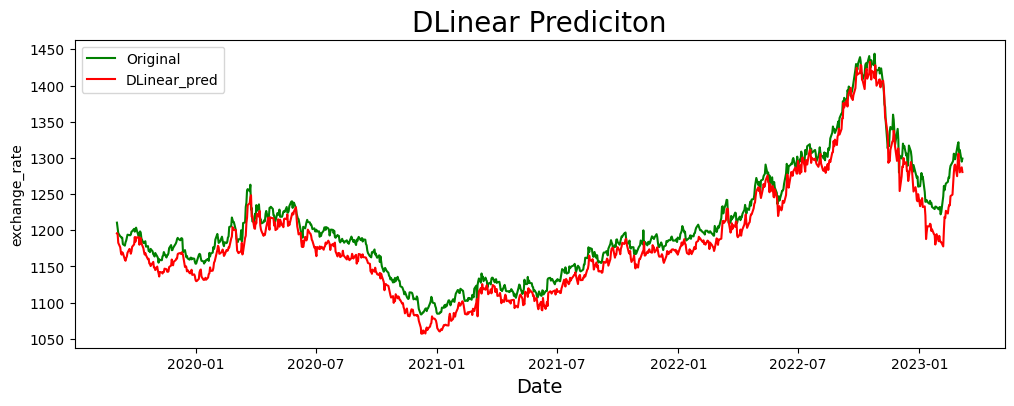

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 4))
plt.plot(prediction_df.date, prediction_df.real,  color='g', label = 'Original')
plt.plot(prediction_df.date, prediction_df.pred,  color='r', label = 'DLinear_pred')

plt.title('DLinear Prediciton', fontsize=20) 

plt.ylabel('exchange_rate', fontsize=10)

plt.xlabel('Date', fontsize=14)

plt.legend()

plt.show()

- test data 결과 확인자료
- 915 window 개수인 test data 구간
- 조건 : forecasting time step : 24, look back window size : 72
- multi - step으로 예측했는데 맨 앞에 값만 뽑아내서 쌓은 후 최종 결과 반환
- 해석
    1) 추세선을 비교적 잘 따라간다.
    2) lagging 현상이 잘 나타나지 않는다.
    3) 급락율이 큰 곳은 좀 더 민감하게 변동폭을 반응하지 못하는 아쉬움이 있다.
    4) 데이터가 많아서 그런가 생각보다 잘 예측하는 것 같다.

### 환율 데이터 확인

In [37]:
extn_data = pd.read_parquet('./data/230215_extn_data.parquet')

In [38]:
extn_data

,EXTN_VAR_DS_CD,EXTN_VAR_DS_NM,EXTN_VAR_CD,EXTN_VAR_NM,BAS_DATE,BAS_VALUE
0,ER,환율,AED,아랍에미리트 디르함,20120102,3.140000e+02
1,ER,환율,AED,아랍에미리트 디르함,20120103,3.145900e+02
2,ER,환율,AED,아랍에미리트 디르함,20120104,3.133500e+02
3,ER,환율,AED,아랍에미리트 디르함,20120105,3.123900e+02
4,ER,환율,AED,아랍에미리트 디르함,20120106,3.131800e+02
...,...,...,...,...,...,...
129486,PPS_CC,조달청 건축공사비,BTYP106,사무시설,202202,1.802872e+10
129487,PPS_CC,조달청 건축공사비,BTYP106,사무시설,202203,1.623435e+10
129488,PPS_CC,조달청 건축공사비,BTYP106,사무시설,202204,2.718449e+10
129489,PPS_CC,조달청 건축공사비,BTYP106,사무시설,202205,6.542083e+10


In [39]:
# BAS_DATE 형식을 맞춰주기 위해 먼저 확인
EXTN_VAR_DS_NMs = sorted(extn_data['EXTN_VAR_DS_NM'].unique())
for nm in EXTN_VAR_DS_NMs:
    mask = (extn_data['EXTN_VAR_DS_NM']==nm)
    print(nm)
    print(extn_data[mask]['BAS_DATE'].unique()[0:3], '\n')

# 일단 여기서 표준적인 날짜 형식이랑 다른 것들
# KOSIS 엔지니어링 노임단가, 산업통상자원부, 한국무역협회, 환율

KOREA_PDS
['201201' '201202' '201203'] 

KOSIS 공사비지수
['201501' '201502' '201503'] 

KOSIS 노임단가
['201506' '201512' '201606'] 

KOSIS 생산자 물가지수(기본분류)
['201501' '201502' '201503'] 

KOSIS 소비자 물가지수
['201501' '201502' '201503'] 

KOSIS 엔지니어링 노임단가
['2015' '2016' '2017'] 

KOSIS 총산출 물가지수
['201501' '201502' '201503'] 

산업통상자원부
['2014-03' '2014-04' '2014-05'] 

월별 환율
['200501' '200502' '200503'] 

자동차용경유
['201601' '201602' '201603'] 

조달청 건축공사비
['201504' '201505' '201506'] 

최저임금
['20150101' '20160101' '20170101'] 

한국무역협회
['201401' '2014-01' '201402'] 

한국물가협회
['201601' '201602' '201603'] 

환율
['20120102' '20120103' '20120104'] 



In [44]:
extn_data = pd.read_parquet('./data/230215_extn_data.parquet')
# # BAS_DATE 형식 통일하기
# extn_data['BAS_DATE'] = extn_data['BAS_DATE'].str.replace('-','')


# 일별 환율을 월별로 평균내어서 사용
mask = (extn_data['EXTN_VAR_DS_NM'] == '환율')

# primary key 하나의 컬럼으로 합쳐주기 (4개를 다 들고다니기에 불편하다.)
extn_data['extn_key'] = extn_data.apply(lambda x: f"{x['EXTN_VAR_DS_CD']}___{x['EXTN_VAR_DS_NM']}___{x['EXTN_VAR_CD']}___{x['EXTN_VAR_NM']}", axis=1)
extn_data = extn_data[['extn_key', 'BAS_DATE', 'BAS_VALUE']]
extn_data

,extn_key,BAS_DATE,BAS_VALUE
0,ER___환율___AED___아랍에미리트 디르함,20120102,3.140000e+02
1,ER___환율___AED___아랍에미리트 디르함,20120103,3.145900e+02
2,ER___환율___AED___아랍에미리트 디르함,20120104,3.133500e+02
3,ER___환율___AED___아랍에미리트 디르함,20120105,3.123900e+02
4,ER___환율___AED___아랍에미리트 디르함,20120106,3.131800e+02
...,...,...,...
129486,PPS_CC___조달청 건축공사비___BTYP106___사무시설,202202,1.802872e+10
129487,PPS_CC___조달청 건축공사비___BTYP106___사무시설,202203,1.623435e+10
129488,PPS_CC___조달청 건축공사비___BTYP106___사무시설,202204,2.718449e+10
129489,PPS_CC___조달청 건축공사비___BTYP106___사무시설,202205,6.542083e+10


In [51]:
extn_data['extn_key'].value_counts().head(28)

ER___환율___USD___미국 달러                 3950
ER___환율___EUR___유로                    3950
ER___환율___AUD___호주 달러                 3944
ER___환율___SGD___싱가포르 달러               3944
ER___환율___SAR___사우디 리얄                3944
ER___환율___GBP___영국 파운드                3944
ER___환율___JPY___JPY                   3928
ER___환율___USD3___USD3                 3837
ER___환율___CHF___스위스 프랑                3088
ER___환율___CAD___캐나다 달러                2673
ER___환율___HKD___홍콩 달러                 2672
ER___환율___SEK___스웨덴 크로나               2661
ER___환율___PHP___PHP                   2020
ER___환율___MYR___말레이지아 링기트             1556
ER___환율___THB___태국 바트                 1556
ER___환율___NZD___뉴질랜드 달러               1556
ER___환율___NOK___노르웨이 크로네              1556
ER___환율___AED___아랍에미리트 디르함            1556
ER___환율___KRW___한국 원                  1556
ER___환율___JPY(100)___일본 옌             1556
ER___환율___IDR(100)___인도네시아 루피아        1556
ER___환율___DKK___덴마아크 크로네              1556
ER___환율___BHD___바레인 디나르               1556
ER___환율___K

- 위에서 1000개 이상의 date가 있는 데이터 모두 적용
- 주로 환율이다.

In [31]:
extn_data[extn_data['EXTN_VAR_DS_NM']=='환율']

,EXTN_VAR_DS_CD,EXTN_VAR_DS_NM,EXTN_VAR_CD,EXTN_VAR_NM,BAS_DATE,BAS_VALUE
0,ER,환율,AED,아랍에미리트 디르함,201201,314.000000
1,ER,환율,AED,아랍에미리트 디르함,201201,314.589996
2,ER,환율,AED,아랍에미리트 디르함,201201,313.350006
3,ER,환율,AED,아랍에미리트 디르함,201201,312.390015
4,ER,환율,AED,아랍에미리트 디르함,201201,313.179993
...,...,...,...,...,...,...
64833,ER,환율,USD3,USD3,202207,1299.800049
64834,ER,환율,USD3,USD3,202207,1299.800049
64835,ER,환율,USD3,USD3,202207,1294.199951
64836,ER,환율,USD3,USD3,202207,1297.900024
